""""""""
Created by Qianqian Song -- for their Song et al. 2022 paper
""""""""

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import sys
from netCDF4 import Dataset

In [2]:
# Single particle optical properties (Mie calculations in my case)
Mie_RI_dir = '/home/cd11735/zzbatmos_user/Dust_Global_DRE/Dust_Optical_Properties/Mie_sphere/\
single_particle_properties_DiffRI_Mie/DB2019SW_BalkanskiSW_DB2017LW_SingleScattering/'

Mie_fname = Mie_RI_dir + 'Single_Scattering_RI_Mean.nc'
dataset = Dataset(Mie_fname)
Qe_Mie = dataset.variables['ExtinctionEfficiency'][:] #dim:[D,wl]
ang_Mie = dataset.variables['PhaseFunctionAngle'][:]
alb_Mie = dataset.variables['SingleScatteringAlbedo'][:]
p11_Mie = dataset.variables['P11'][:] #dim: [6000 Diameters, 60 wl, 360 angles]
g_Mie  = dataset.variables['AsymmetryFactor'][:]  
wl_mie = dataset.variables['Wavelength'][:]
D_Mie = dataset.variables['Diameter'][:]
r_Mie = D_Mie/2
rad = ang_Mie*np.pi/180

/tmp/ipykernel_11862/4145696185.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Qe_Mie = dataset.variables['ExtinctionEfficiency'][:] #dim:[D,wl]
/tmp/ipykernel_11862/4145696185.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ang_Mie = dataset.variables['PhaseFunctionAngle'][:]
/tmp/ipykernel_11862/4145696185.py:9: DeprecationWarning: `np.b

In [3]:
#define filenames to save the data
Qe_sw_fname = 'Qe_bins_swbands_MeanRI.txt'
ssa_sw_fname = 'ssa_bins_swbands_MeanRI.txt'
g_sw_fname = 'g_bins_swbands_MeanRI.txt'
Qe_lw_fname = 'Qe_bins_lwbands_MeanRI.txt'
ssa_lw_fname = 'ssa_bins_lwbands_MeanRI.txt'
g_lw_fname = 'g_bins_lwbands_MeanRI.txt'

Qe_fname_bulk = 'Qe_bins_bulk_MeanRI.txt'
ssa_fname_bulk = 'ssa_bins_bulk_MeanRI.txt'
g_fname_bulk = 'g_bins_bulk_MeanRI.txt'

In [4]:
#Define size bins; Diameter cutoff at 100um
D_min     = 0.1 #set the minimum diameter for Optical Properties calculations
D_max     = 100
D_mie_mask = (D_Mie>=D_min) & (D_Mie<=D_max)
D_mie = D_Mie[D_mie_mask]
Qe_mie = Qe_Mie[D_mie_mask,:]
alb_mie = alb_Mie[D_mie_mask,:]
g_mie = g_Mie[D_mie_mask,:]
Nd_mie = np.size(D_mie)
Nwl    = np.size(wl_mie) #60
Nbin=10
bin_edge = np.logspace(-1,2,Nbin+1)

In [5]:
print(bin_edge)

[  0.1          0.19952623   0.39810717   0.79432823   1.58489319
   3.16227766   6.30957344  12.58925412  25.11886432  50.11872336
 100.        ]


In [7]:
#=====calculate bulk averaged Qe, w, g for each size bin and each wavelengh=====
#define bulk averaged Qe, omega, g for each size bin
Qe_bulk_bins = np.zeros((Nbin, Nwl))
alb_bulk_bins = np.zeros((Nbin, Nwl))
g_bulk_bins = np.zeros((Nbin, Nwl))

In [8]:
#sub-bin size distribution
# Note! in Song et al. 2022 study, dust particle number (dN/dD) is assumed to be uniformly distributed. 
# Therefore, dN/dD ('n_d') = 1 in this study. If you would account for sub-bin size distribution, you can replace this to any sub-bin size distribution.
n_d =1


for ib in range(Nbin):
    for iw in range(Nwl):
        D_low = bin_edge[ib]
        D_up  = bin_edge[ib+1]
        D_bin_mask = (D_mie >= D_low) & (D_mie < D_up)
        D_bin = D_mie[D_bin_mask]
        A_ave     = integrate.trapz(np.pi*(D_bin/2)**2*n_d,D_bin)
        Cext_ave  = integrate.simps(Qe_mie[D_bin_mask,iw]*np.pi*(D_bin/2)**2*n_d,D_bin)
        Cscat_ave = integrate.trapz(alb_mie[D_bin_mask,iw]*Qe_mie[D_bin_mask,iw]*np.pi*(D_bin/2)**2*n_d,D_bin)
        gwQeA_bulkave = integrate.trapz(g_mie[D_bin_mask,iw]*alb_mie[D_bin_mask,iw]*Qe_mie[D_bin_mask,iw]*np.pi*(D_bin/2)**2*n_d,D_bin)

        Qe_bulk_bins[ib,iw]  = Cext_ave/A_ave
        alb_bulk_bins[ib,iw] = Cscat_ave/Cext_ave
        g_bulk_bins[ib,iw] = gwQeA_bulkave/Cscat_ave

In [9]:
print(Qe_bulk_bins.shape)
# np.savetxt('wl_mie.txt',wl_mie,fmt='%8.4f')
# np.savetxt(Qe_fname_bulk,Qe_bulk_bins,fmt='%5.3f')
# np.savetxt(ssa_fname_bulk,alb_bulk_bins,fmt='%5.3f')
# np.savetxt(g_fname_bulk,g_bulk_bins,fmt='%5.3f')

(10, 144)


In [10]:
#=====spectral averaged Qe, w, g=====
def Planck(wavelength,T):
    # in W/m^2/um unit
    # First write Plank's Function, which is in W/m2/sr/um
    h=6.626e-34
    kb=1.38e-23
    c=3e8
    #wvl in m unit
    wvl = 1e-6*wavelength
    a = 2.0*h*c**2
    b = h*c/(wvl*kb*T)
    # The unit of B_wvlandT is W/m2/m/str
    B_wvlandT = a/(wvl**5*(np.exp(h*c/wvl/kb/T)-1))
    # Convert to W/m2/um/str
    B_wvlandT = 1e-6*B_wvlandT
    return(B_wvlandT)

In [11]:
def lw_spectral_ave(ibin):
    Qe_bulk_ave   = Qe_bulk_bins[ibin,:]
    alb_bulk_ave  = alb_bulk_bins[ibin,:]
    g_bulk_ave    = g_bulk_bins[ibin,:]
    temp = 287 # temperature
    #wl_interp = np.linspace(wl_mie[0],wl_mie[-1],5000)
    wl_interp = np.logspace(-1,3,5000)[ (np.logspace(-1,3,5000)>=wl_mie[0]) & (np.logspace(-1,3,5000)<=wl_mie[-1]) ]
    f_Qe = interp1d(wl_mie,Qe_bulk_ave,'linear')
    f_alb = interp1d(wl_mie,alb_bulk_ave,'linear')
    f_g = interp1d(wl_mie,g_bulk_ave,'linear')
    Qe_bulk_ave = f_Qe(wl_interp)
    alb_bulk_ave = f_alb(wl_interp)
    g_bulk_ave = f_g(wl_interp)
    B_wlandT = Planck(wl_interp,temp)
    Wavenumber = np.array((10,350,500,630,700,820,980,1080,1180,1390,1480,1800,2080,2250,2380,2600,3250))
    Wavelength = (1e4+ np.zeros(len(Wavenumber)))/Wavenumber
    Qe_spec_ave = np.zeros(16)
    alb_spec_ave = np.zeros(16)
    g_spec_ave = np.zeros(16)
    for i in range(16):
        Qe_up = alb_up = g_up = 0
        index = (wl_interp < Wavelength[i]) & (wl_interp > Wavelength[i+1])
        dem = integrate.trapz(B_wlandT[index],wl_interp[index])
        Qe_up = integrate.trapz(Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])
        alb_up = integrate.trapz(alb_bulk_ave[index]*Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])
        g_up = integrate.trapz(g_bulk_ave[index]*alb_bulk_ave[index]*Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])
        Qe_spec_ave[i] ='%6.3f'%(Qe_up/dem)
        alb_spec_ave[i] ='%6.3f'%( alb_up / Qe_up)
        g_spec_ave[i] ='%6.3f'%( g_up / alb_up)
    return(Qe_spec_ave,alb_spec_ave,g_spec_ave)

In [12]:
def sw_spectral_ave(ibin):
    Qe_bulk_ave   = Qe_bulk_bins[ibin,:]
    alb_bulk_ave  = alb_bulk_bins[ibin,:]
    g_bulk_ave    = g_bulk_bins[ibin,:]
    temp = 5800 # temperature
    #wl_interp = np.linspace(wl_mie[0],wl_mie[-1],5000)
    wl_interp = np.logspace(-1,3,5000)[ (np.logspace(-1,3,5000)>=wl_mie[0]) & (np.logspace(-1,3,5000)<=wl_mie[-1]) ]
    f_Qe = interp1d(wl_mie,Qe_bulk_ave,'linear')
    f_alb = interp1d(wl_mie,alb_bulk_ave,'linear')
    f_g = interp1d(wl_mie,g_bulk_ave,'linear')
    Qe_bulk_ave = f_Qe(wl_interp)
    alb_bulk_ave = f_alb(wl_interp)
    g_bulk_ave = f_g(wl_interp)
    B_wlandT   = Planck(wl_interp,temp)
    Wavenumber = np.array((820,2600,3250,4000,4650,5150,6150,7700,8050,12850,16000,22650,29000,38000,50000))
    Wavelength = (1e4+ np.zeros(len(Wavenumber)))/Wavenumber
    Qe_spec_ave = np.zeros(14)
    alb_spec_ave = np.zeros(14)
    g_spec_ave = np.zeros(14)
    for i in range(14):
        Qe_up = alb_up = g_up = 0
        index = (wl_interp < Wavelength[i]) & (wl_interp > Wavelength[i+1])
        if np.sum(index) !=0:
            dem = integrate.trapz(B_wlandT[index],wl_interp[index])
            Qe_up = integrate.trapz(Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])
            alb_up = integrate.trapz(alb_bulk_ave[index]*Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])
            g_up = integrate.trapz(g_bulk_ave[index]*alb_bulk_ave[index]*Qe_bulk_ave[index]*B_wlandT[index],wl_interp[index])

            Qe_spec_ave[i] ='%6.3f' % (Qe_up/dem)
            alb_spec_ave[i] = '%6.3f' %(alb_up / Qe_up)
            g_spec_ave[i] = '%6.3f' %(g_up / alb_up)
            
        else: #for the last band (0.2~0.26um) Bankanski-SW does not have this spectral RI, we make it the same as the ajacent band
            Qe_spec_ave[i] = Qe_spec_ave[i-1]
            alb_spec_ave[i]= alb_spec_ave[i-1]
            g_spec_ave[i]  = g_spec_ave[i-1]    
        

    return(Qe_spec_ave,alb_spec_ave,g_spec_ave)

In [13]:
#spectral ave Qe, w, g
Qe_lw   = np.zeros((Nbin, 16))
alb_lw  = np.zeros((Nbin, 16))
g_lw    = np.zeros((Nbin, 16))
Qe_sw   = np.zeros((Nbin, 14))
alb_sw  = np.zeros((Nbin, 14))
g_sw    = np.zeros((Nbin, 14))
for i in range(Nbin):
    #LW band-ave scattering proeprties (16 bands)
    #     Band    Wavenumber                   1050 - 96 mb      96 - 0.01 mb    Halocarbons  
    #        Range (cm-1)			

    # 1       10 -  350		         H2O,N2~          H2O,N2~	   ----
    # 2      350 -  500		          H2O              H2O		   ----
    # 3      500 -  630		      H2O,CO2,N2O~     H2O,CO2,N2O~	   ----
    # 4      630 -  700		        H2O,CO2          CO2,O3 	   ----
    # 5      700 -  820		        H2O,CO2,O3~      CO2,O3		   CCL4
    # 6      820 -  980		        H2O,CO2~           --- 	       CFC11^,CFC12
    # 7      980 - 1080		      H2O,O3,CO2~        O3,CO2	           ----
    # 8     1080 - 1180                  H2O,CO2~,O3~,N2O~   O3,CO2~,N2O~    CFC12,CFC22^
    # 9     1180 - 1390		      H2O,CH4,N2O~         CH4,N2O	   ----
    # 10    1390 - 1480		          H2O              H2O	           ----
    # 11    1480 - 1800		        H2O,O2~          H2O,O2~	   ----
    # 12    1800 - 2080		        H2O,CO2            ---		   ----
    # 13    2080 - 2250	            H2O,N2O,CO2~,CO~       O3~		   ----
    # 14    2250 - 2380		          CO2              CO2		   ----
    # 15    2380 - 2600		    N2O,CO2,WV~,N2~        ---		   ----
    # 16    2600 - 3250		        H2O,CH4            CH4		   ----

    Qe_lw[i,:], alb_lw[i,:], g_lw[i,:] = lw_spectral_ave(i)
    
    
    #         Band #   Wavenumber Range (cm-1)       1050 - 96 mb      96 - 0.01 mb  

    #[0]      16        2600-3250                     H2O,CH4             CH4
    #[1]      17        3250-4000                     H2O,CO2           H2O,CO2
    #[2]      18        4000-4650                     H2O,CH4             CH4
    #[3]      18        4650-5150                     H2O,CO2             CO2
    #[4]      20        5150-6150                     H2O,CH4*          H2O,CH4*
    #[5]      21        6150-7700                     H2O,CO2           H2O,CO2
    #[6]      22        7700-8050                     H2O,O2              O2
    #[7]      23        8050-12850                      H2O             nothing
    #[8]      24       12850-16000                   H2O,O2,O3*          O2,O3*
    #[9]      25       16000-22650                    H2O,O3*             O3*
    #[10]      26       22650-29000                    nothing           nothing
    #[11]      20       29000-38000                      O3                O3
    #[12]      28       38000-50000                     O3,O2            O3,O2
    #[13]      29         820-2600                       H2O               CO2

    #SW band-ave scattering proeprties (14 bands). Note: make the order of the band to be consistent with RRTM instrictuions
    Qe_sw_temp, alb_sw_temp, g_sw_temp = sw_spectral_ave(i)
    Qe_sw[i,:] = np.append(Qe_sw_temp[1:],Qe_sw_temp[0])
    alb_sw[i,:] = np.append(alb_sw_temp[1:],alb_sw_temp[0])
    g_sw[i,:] = np.append(g_sw_temp[1:],g_sw_temp[0])
    

np.savetxt(Qe_lw_fname,Qe_lw,fmt='%5.3f')
np.savetxt(ssa_lw_fname,alb_lw,fmt='%5.3f')
np.savetxt(g_lw_fname,g_lw,fmt='%5.3f')
np.savetxt(Qe_sw_fname,Qe_sw,fmt='%5.3f')
np.savetxt(ssa_sw_fname,alb_sw,fmt='%5.3f')
np.savetxt(g_sw_fname,g_sw,fmt='%5.3f')

## Plot spectral Qe, ssa, g

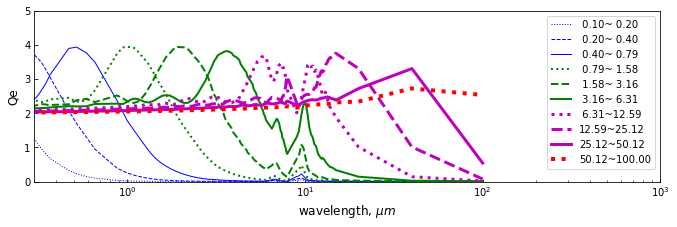

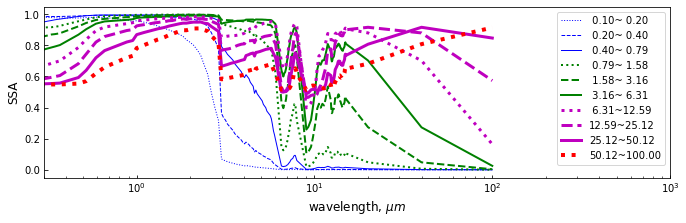

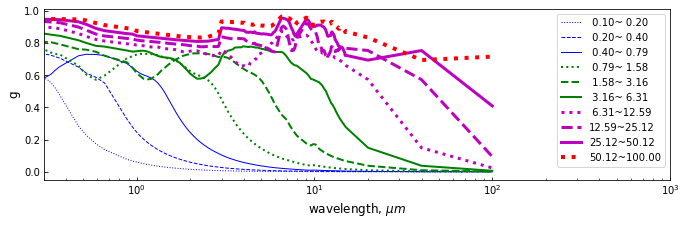

In [14]:
fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie,Qe_bulk_bins[0,:],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie,Qe_bulk_bins[1,:],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie,Qe_bulk_bins[2,:],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie,Qe_bulk_bins[3,:],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie,Qe_bulk_bins[4,:],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie,Qe_bulk_bins[5,:],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie,Qe_bulk_bins[6,:],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie,Qe_bulk_bins[7,:],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
ax.plot(wl_mie,Qe_bulk_bins[8,:],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
ax.plot(wl_mie,Qe_bulk_bins[9,:],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
ax.set_xscale('log')
ax.set_xlim(0.3,1e3)
ax.set_ylim(0,5)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('Qe',fontsize=12)
plt.subplots_adjust(left=0.08,right=0.95,top=0.94,\
                    bottom=0.15,wspace=0.25,hspace=0.28)
#plt.savefig('SizeBin-resolved-Qe-Mie.png',dpi=300)

fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie,alb_bulk_bins[0,:],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie,alb_bulk_bins[1,:],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie,alb_bulk_bins[2,:],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie,alb_bulk_bins[3,:],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie,alb_bulk_bins[4,:],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie,alb_bulk_bins[5,:],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie,alb_bulk_bins[6,:],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie,alb_bulk_bins[7,:],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
ax.plot(wl_mie,alb_bulk_bins[8,:],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
ax.plot(wl_mie,alb_bulk_bins[9,:],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
ax.set_xscale('log')
ax.set_xlim(0.3,1e3)
#ax.set_ylim(0,0.2)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('SSA',fontsize=12)
plt.subplots_adjust(left=0.08,right=0.95,top=0.94,\
                    bottom=0.15,wspace=0.25,hspace=0.28)
#plt.savefig('SizeBin-resolved-SSA-Mie.png',dpi=300)

fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie,g_bulk_bins[0,:],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie,g_bulk_bins[1,:],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie,g_bulk_bins[2,:],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie,g_bulk_bins[3,:],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie,g_bulk_bins[4,:],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie,g_bulk_bins[5,:],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie,g_bulk_bins[6,:],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie,g_bulk_bins[7,:],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
ax.plot(wl_mie,g_bulk_bins[8,:],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
ax.plot(wl_mie,g_bulk_bins[9,:],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
ax.set_xscale('log')
ax.set_xlim(0.3,1e3)
#ax.set_ylim(0,0.2)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('g',fontsize=12)

plt.subplots_adjust(left=0.08,right=0.95,top=0.94,\
                    bottom=0.15,wspace=0.25,hspace=0.28)
#plt.savefig('SizeBin-resolved-g-Mie.png',dpi=300)

Text(0, 0.5, 'g')

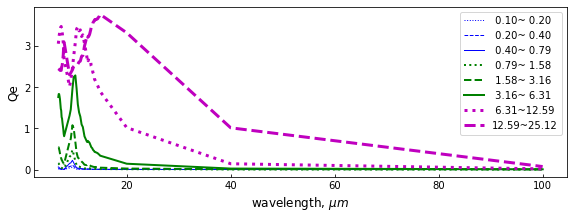

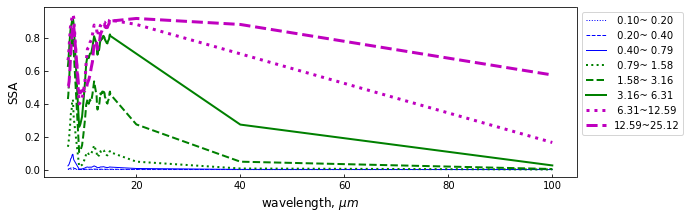

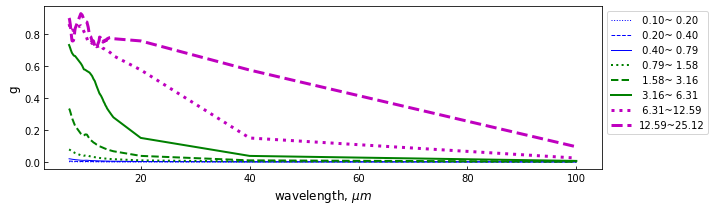

In [15]:

fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie[80:205],Qe_bulk_bins[0,80:205],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[1,80:205],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[2,80:205],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[3,80:205],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[4,80:205],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[5,80:205],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[6,80:205],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie[80:205],Qe_bulk_bins[7,80:205],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
# ax.plot(wl_mie[80:205],Qe_bulk_bins[8,80:205],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
# ax.plot(wl_mie[80:205],Qe_bulk_bins[9,80:205],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
# ax.set_xscale('log')
# ax.set_xlim(0.3,1e3)
# ax.set_ylim(0,4)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('Qe',fontsize=12)
plt.subplots_adjust(left=0.08,right=0.82,top=0.94,\
                    bottom=0.15,wspace=0.25,hspace=0.28)
plt.savefig('SizeBin-resolved-Qe-Mie.png',dpi=300)

fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie[80:205],alb_bulk_bins[0,80:205],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie[80:205],alb_bulk_bins[1,80:205],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie[80:205],alb_bulk_bins[2,80:205],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie[80:205],alb_bulk_bins[3,80:205],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie[80:205],alb_bulk_bins[4,80:205],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie[80:205],alb_bulk_bins[5,80:205],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie[80:205],alb_bulk_bins[6,80:205],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie[80:205],alb_bulk_bins[7,80:205],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
# ax.plot(wl_mie[80:205],alb_bulk_bins[8,80:205],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
# ax.plot(wl_mie[80:205],alb_bulk_bins[9,80:205],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
# ax.set_xscale('log')
# ax.set_xlim(0.3,1e3)
#ax.set_ylim(0,0.2)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('SSA',fontsize=12)
plt.subplots_adjust(left=0.08,right=0.82,top=0.94,\
                    bottom=0.15,wspace=0.25,hspace=0.28)
plt.savefig('SizeBin-resolved-SSA-Mie.png',dpi=300)

fig,ax=plt.subplots(figsize=(10,3))
ax.plot(wl_mie[80:205],g_bulk_bins[0,80:205],lw=1,ls='dotted',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[0],bin_edge[1]))
ax.plot(wl_mie[80:205],g_bulk_bins[1,80:205],lw=1,ls='dashed',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[1],bin_edge[2]))
ax.plot(wl_mie[80:205],g_bulk_bins[2,80:205],lw=1,ls='solid',c='b',label='{:5.2f}~{:5.2f}'.format(bin_edge[2],bin_edge[3]))
ax.plot(wl_mie[80:205],g_bulk_bins[3,80:205],lw=2,ls='dotted',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[3],bin_edge[4]))
ax.plot(wl_mie[80:205],g_bulk_bins[4,80:205],lw=2,ls='dashed',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[4],bin_edge[5]))
ax.plot(wl_mie[80:205],g_bulk_bins[5,80:205],lw=2,ls='solid',c='g',label='{:5.2f}~{:5.2f}'.format(bin_edge[5],bin_edge[6]))
ax.plot(wl_mie[80:205],g_bulk_bins[6,80:205],lw=3,ls='dotted',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[6],bin_edge[7]))
ax.plot(wl_mie[80:205],g_bulk_bins[7,80:205],lw=3,ls='dashed',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[7],bin_edge[8]))
# ax.plot(wl_mie[80:205],g_bulk_bins[8,80:205],lw=3,ls='solid',c='m',label='{:5.2f}~{:5.2f}'.format(bin_edge[8],bin_edge[9]))
# ax.plot(wl_mie[80:205],g_bulk_bins[9,80:205],lw=4,ls='dotted',c='r',label='{:5.2f}~{:5.2f}'.format(bin_edge[9],bin_edge[10]))
# ax.set_xscale('log')
# ax.set_xlim(0.3,1e3)
#ax.set_ylim(0,0.2)
ax.legend(bbox_to_anchor=(1.0, 1))
ax.tick_params(axis='both',which='both',direction='in')
ax.set_xlabel('wavelength, $\mu m$',fontsize=12)
ax.set_ylabel('g',fontsize=12)
